### A simple implementation of the paper Learning both weights and connections

In [35]:
from torchvision import datasets, transforms
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

### Import local modules, they can be found in the repo as .py files

In [37]:
# defines modules
from model import LeNet

# evaluates the model
from eval_model import evaluate_model

# loads the mnist set
import mnist_loader

# trains the model
from train import Trainer

In [4]:
model=LeNet()
# Model class must be defined somewhere
model = torch.load('lenet_model')
model.eval()

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
learning_rate=.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
epoches=20
bs=32

In [38]:
# load data
train_set, test_set=mnist_loader.get_x_and_y()

## pruning library

In [7]:
import torch.nn.utils.prune as prune

In [8]:
result=evaluate_model(model,test_set)

In [9]:
train=Trainer(model, train_set, criterion, optimizer, epoches, 100)

In [10]:
baseline=result.evaluate()
baseline=int(baseline)

### The key part of the paper is the threshold
### It is choosen as the standard deviation of the weights of a layer times some constant (.25)

In [11]:
# given a single layer, this func returns the threshold to compress
thrshld_layer = lambda layer: np.std(np.array(layer.state_dict()['weight'])) * .25

In [27]:
# Since the prunning library takes in what percentage of weights to prune, convert the threshold calculated above into a percentage contant
thresh_to_per= lambda layer:np.count_nonzero(np.array(layer.state_dict()['weight']) < thrshld_layer(layer))/torch.numel(layer.state_dict()['weight'])    

In [28]:
# a function to do the actual pruning

def prune_model(model):
#     take all the layers
    layers=[i for i in model.modules()][1:]    
    
#     prune each layer separtley
    for i in layers:
        t=thresh_to_per(i)
#         t is the threshold to prune
        t=t
        prune.l1_unstructured(i, name='weight', amount=t)    
        prune.remove(i, 'weight')

In [13]:
# torch.numel(layers[0].state_dict()['weight_orig'])

In [14]:
# torch.count_nonzero(model.state_dict()['weight'])

In [15]:
# list of all the modules, as layers
layers=[i for i in model.modules()][1:]

# total number of weights 
num_of_weights=sum([torch.numel(i.state_dict()['weight']) for i in layers ])

# total number of parameters, not just weights
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)



# Non zero values in weights ...this is a function, as they keep changing
nonzero_weights= lambda: sum([torch.count_nonzero(i.state_dict()['weight']) for i in layers ])


In [17]:
#  A list to keep the accuracy over time
acc_over_time=[]

#  A list to keep the accuracy over time
zeros_over_time=[]

# A list of the non zeros over time
non_zero_over_time=[]

#
iterate=0

while True:
#     pruning the model
    prune_model(model)
    
#     evaluate model after pruning
    result=evaluate_model(model,test_set) 
    
#     check accuracy
    acc_over_time.append(result.evaluate())  
    
#     zeros over time
    zeros_over_time.append(num_of_weights-nonzero_weights())
    non_zero_over_time.append(nonzero_weights())
    
#     the train module has regularization=0, as per the paper it needs l2 regularization
# setting the train class regulrization !=0, activates l2 regularization
    train.regularization=1
    
#     actual training 
    train.training()


    if iterate >10: #     this is to make the loop stop after 10 cycles, one can go beyond 
        break
    
    iterate+=1
    
    if zeros_over_time[-1]>.3*num_of_weights and acc_over_time[-1]>= baseline-1 :
        print('Weght percentage : ', 100*zeros_over_time[-1]/nonzero_weights(), ' %')
        break    

going for training .. 
0  of  20  epoches 0.19891256093978882
1  of  20  epoches 0.16948336362838745
2  of  20  epoches 0.1275157630443573
3  of  20  epoches 0.12046615034341812
4  of  20  epoches 0.10590507090091705
5  of  20  epoches 0.10500798374414444
6  of  20  epoches 0.09633530676364899
7  of  20  epoches 0.09387662261724472
8  of  20  epoches 0.08919645845890045
9  of  20  epoches 0.08534760028123856
10  of  20  epoches 0.08184483647346497
11  of  20  epoches 0.08042776584625244
12  of  20  epoches 0.0781622901558876
13  of  20  epoches 0.0774068683385849
14  of  20  epoches 0.07611246407032013
15  of  20  epoches 0.07501485198736191
16  of  20  epoches 0.07618924975395203
17  of  20  epoches 0.0758155882358551
18  of  20  epoches 0.07604678720235825
19  of  20  epoches 0.07504326105117798
iter : tensor(34197)
going for training .. 
0  of  20  epoches 0.13511788845062256
1  of  20  epoches 0.11270326375961304
2  of  20  epoches 0.09636440128087997
3  of  20  epoches 0.082546845

17  of  20  epoches 0.028476150706410408
18  of  20  epoches 0.028512125834822655
19  of  20  epoches 0.028832189738750458
iter : tensor(55662)
going for training .. 
0  of  20  epoches 0.05778937786817551
1  of  20  epoches 0.06595449149608612
2  of  20  epoches 0.051719337701797485
3  of  20  epoches 0.046265460550785065
4  of  20  epoches 0.041595734655857086
5  of  20  epoches 0.038883619010448456
6  of  20  epoches 0.0362539067864418
7  of  20  epoches 0.03548145294189453
8  of  20  epoches 0.03803110495209694
9  of  20  epoches 0.03222343698143959
10  of  20  epoches 0.029994551092386246
11  of  20  epoches 0.030745793133974075
12  of  20  epoches 0.02974911406636238
13  of  20  epoches 0.028000473976135254
14  of  20  epoches 0.028976764529943466
15  of  20  epoches 0.026966897770762444
16  of  20  epoches 0.02719465084373951
17  of  20  epoches 0.026397649198770523
18  of  20  epoches 0.026799531653523445
19  of  20  epoches 0.02607615292072296
iter : tensor(55533)
going for tr

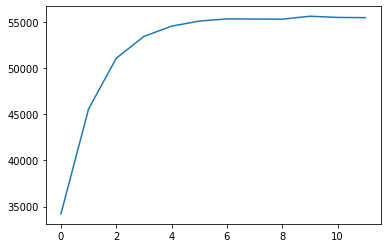

In [18]:
plt.plot(zeros_over_time)

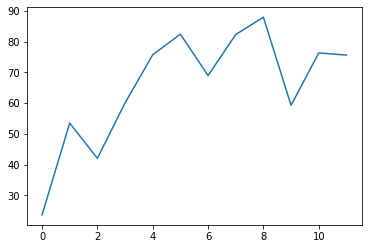

In [19]:
plt.plot(acc_over_time)

In [20]:
model.state_dict()

OrderedDict([('conv1.bias',
              tensor([ 0.0241, -0.1384, -0.0227,  0.0729,  0.0487, -0.1166])),
             ('conv1.weight',
              tensor([[[[-1.1045e-02, -8.7613e-03,  7.9037e-04],
                        [-1.2757e-02, -2.0690e-03,  1.3102e-02],
                        [ 1.9487e-03,  1.5649e-02,  5.4081e-01]]],
              
              
                      [[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
                        [-0.0000e+00, -0.0000e+00,  0.0000e+00],
                        [-0.0000e+00, -0.0000e+00, -0.0000e+00]]],
              
              
                      [[[-0.0000e+00, -0.0000e+00,  0.0000e+00],
                        [-0.0000e+00, -0.0000e+00,  0.0000e+00],
                        [-0.0000e+00,  0.0000e+00,  0.0000e+00]]],
              
              
                      [[[ 6.0741e-01,  6.0310e-01,  6.0772e-01],
                        [ 4.8222e-02,  7.7326e-01,  6.7027e-01],
                        [ 4.4326e-02,  3.0627e-02,  

In [42]:
result=evaluate_model(model,test_set)

In [43]:
last_accuracy=result.evaluate()

In [44]:
last_accuracy

97.73954790958192

In [45]:
num_of_weights

59838

In [26]:
zeros_over_time[-1]

tensor(55509)

In [30]:
59838-55509

4329

In [34]:
100*(4329)/59838

7.234533239747318

### The last accuracy is as good as the baseline but with 4329 less weights(zero)